In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


cs224 
last updated: 2020-03-12 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
xarray 0.11.3
scipy 1.2.1
pandas 0.24.2
sklearn 0.20.3
matplotlib 3.0.3
seaborn 0.9.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [4]:
fname = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
time_series_19_covid_confirmed = pd.read_csv(fname)
fname = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
time_series_19_covid_recovered = pd.read_csv(fname)
fname = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
time_series_19_covid_death = pd.read_csv(fname)

In [5]:
time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149


In [6]:
columns = time_series_19_covid_confirmed.columns[4:]
dcolumns = [pd.to_datetime(dt) for dt in columns]
columns[:3],dcolumns[-3:]

(Index(['1/22/20', '1/23/20', '1/24/20'], dtype='object'),
 [Timestamp('2020-03-09 00:00:00'),
  Timestamp('2020-03-10 00:00:00'),
  Timestamp('2020-03-11 00:00:00')])

In [7]:
# ldf_confirmed = time_series_19_covid_confirmed[columns][time_series_19_covid_confirmed['Country/Region'].isin(['US'])]
# pd.DataFrame(ldf_confirmed.sum(axis=0), columns=['sum']).T

In [8]:
def get_cases_by_selector(selector):
    ldf_confirmed = time_series_19_covid_confirmed[columns][selector]
    ldf_recovered = time_series_19_covid_recovered[columns][selector]
    ldf_death     = time_series_19_covid_death[columns][selector]
    
    if(len(ldf_confirmed) > 1):
        ldf_confirmed = pd.DataFrame(ldf_confirmed.sum(axis=0), columns=['sum']).T
        ldf_recovered = pd.DataFrame(ldf_recovered.sum(axis=0), columns=['sum']).T
        ldf_death     = pd.DataFrame(ldf_death.sum(axis=0), columns=['sum']).T
    
    ldf              = pd.DataFrame(index=dcolumns)
    ldf['confirmed'] = ldf_confirmed.T.values
    ldf['recovered'] = ldf_recovered.T.values
    ldf['death']     = ldf_death.T.values
    
    lv = ldf['confirmed'].iloc[1:].values - ldf['confirmed'].iloc[:-1].values
    ldf['new_confirmed'] = np.concatenate([np.array([0]),lv])

    lv = ldf['recovered'].iloc[1:].values - ldf['recovered'].iloc[:-1].values
    ldf['new_recovered'] = np.concatenate([np.array([0]),lv])

    lv = ldf['death'].iloc[1:].values - ldf['death'].iloc[:-1].values
    ldf['new_death'] = np.concatenate([np.array([0]),lv])
    
    return ldf

def get_cases_by_region(region='Germany'):
    if isinstance(region, str):
        region=[region]
    return get_cases_by_selector(time_series_19_covid_confirmed['Country/Region'].isin(region))

df = get_cases_by_region()
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-07,799,18,0,129,1,0
2020-03-08,1040,18,0,241,0,0
2020-03-09,1176,18,2,136,0,2
2020-03-10,1457,18,2,281,0,0
2020-03-11,1908,25,3,451,7,1


* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [9]:
# ldf = get_cases_by_region(region='US')
# ldf.tail()

In [10]:
class CasesByRegion():
    def __init__(self, region):
        self.df = get_cases_by_region(region=region)
        
    def tail(self):
        return self.df.tail()
        
    def plot_daily_stats(self):
        fig=plt.figure(figsize=(32, 8), dpi= 80, facecolor='w', edgecolor='k')
        ax = plt.subplot(1, 1, 1)
        last_day = self.df.index[-1]
        # self.df[['new_confirmed', 'recovered', 'death']].loc[last_day + datetime.timedelta(days=-20):].plot.bar(ax=ax)
        self.df[['new_confirmed', 'new_recovered', 'new_death']].loc[last_day + datetime.timedelta(days=-20):].plot.bar(ax=ax)
        plt.tick_params(labelright=True) # labeltop=True,         
        
    def plot_daily_stacked(self):        
        fig=plt.figure(figsize=(32, 8), dpi= 80, facecolor='w', edgecolor='k')
        ax = plt.subplot(1, 1, 1)
        last_day = self.df.index[-1]
        ldf_ = self.df
        ldf = ldf_[['confirmed', 'new_confirmed']].copy()
        ldf['confirmed'] = ldf['confirmed'] - ldf['new_confirmed']
        ldf[['confirmed', 'new_confirmed']].loc[last_day + datetime.timedelta(days=-20):].plot.bar(ax=ax, stacked=True)

        totals = []
        # find the values and append to list
        for i in ax.patches:
            totals.append(i.get_height())

        # set individual bar lables using above list
        total = sum(totals)

        l = len(totals)//2
        lv = ldf_['confirmed'].values[-l:]
        # set individual bar lables using above list
        for i in range(l):
            p1 = ax.patches[i]
            p2 = ax.patches[l+i]
            # get_x pulls left or right; get_height pushes up or down
            ax.text(p1.get_x()+.08, p1.get_height()+p2.get_height()+.5, lv[i], fontsize=15, color='dimgrey')

        plt.tick_params(labelright=True) # labeltop=True, 
        #ax.yaxis.set_label_position("right")
        #ax.yaxis.tick_right()        

In [11]:
cbr_germany = CasesByRegion('Germany')
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-07,799,18,0,129,1,0
2020-03-08,1040,18,0,241,0,0
2020-03-09,1176,18,2,136,0,2
2020-03-10,1457,18,2,281,0,0
2020-03-11,1908,25,3,451,7,1


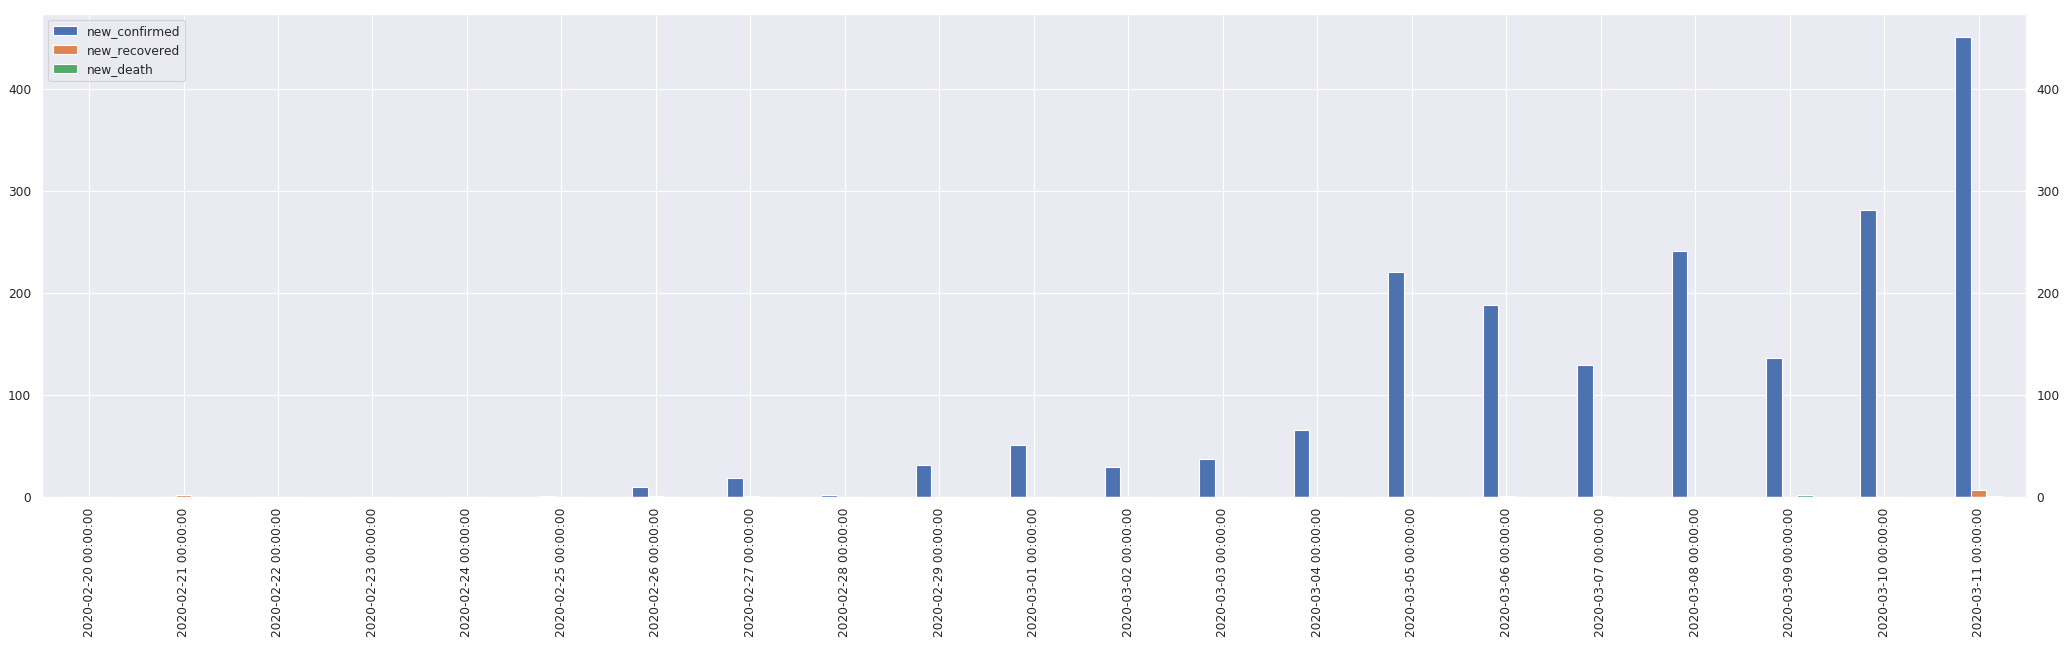

In [12]:
cbr_germany.plot_daily_stats()

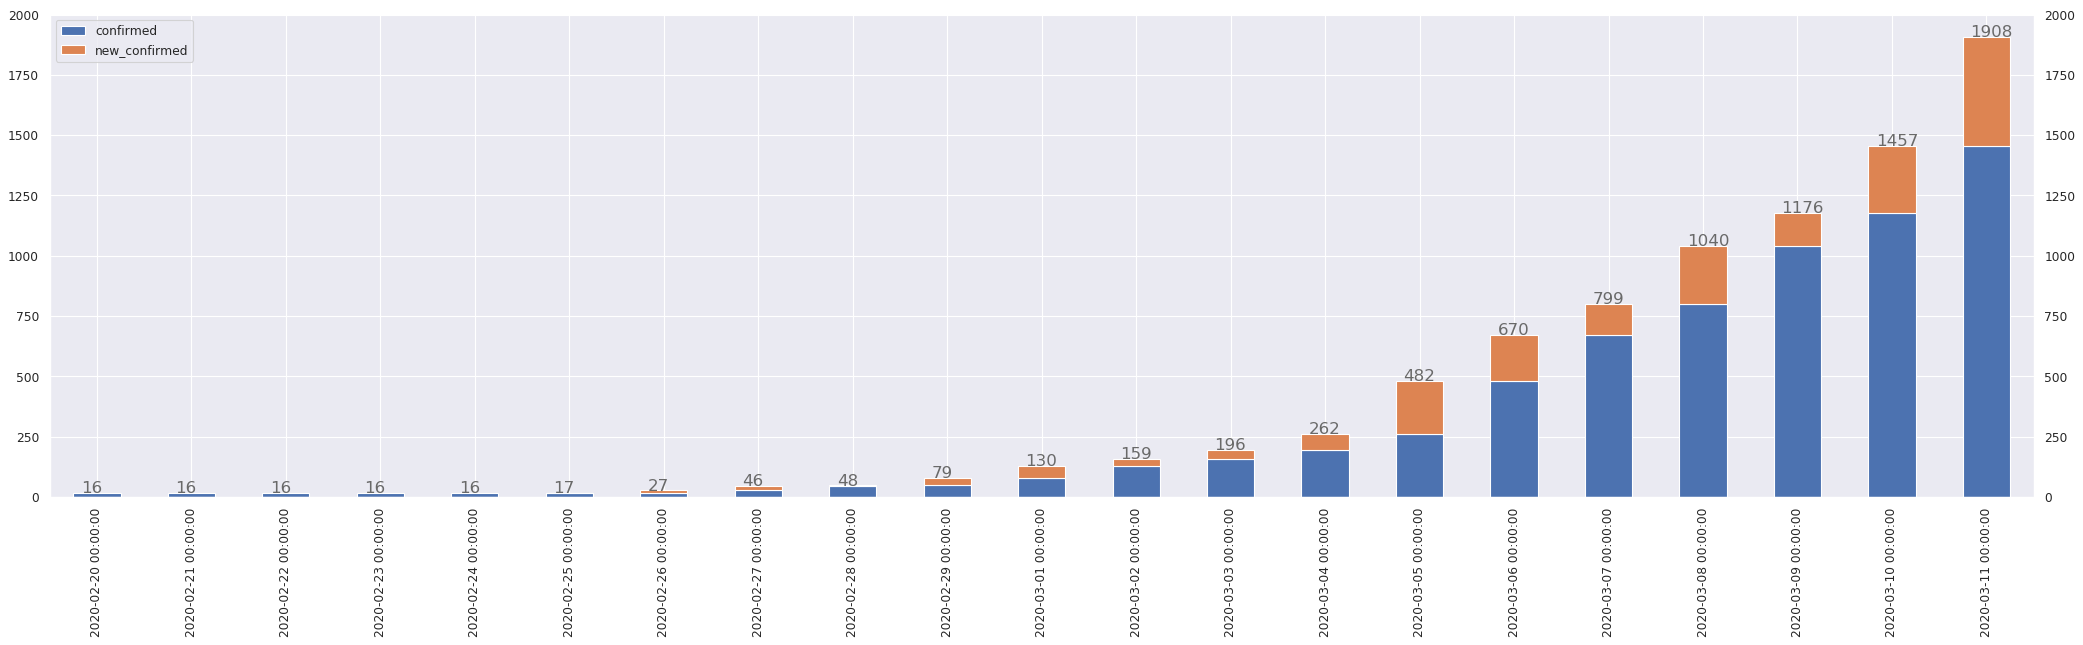

In [13]:
cbr_germany.plot_daily_stacked()

In [14]:
cbr_italy = CasesByRegion('Italy')
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-07,5883,589,233,1247,66,36
2020-03-08,7375,622,366,1492,33,133
2020-03-09,9172,724,463,1797,102,97
2020-03-10,10149,724,631,977,0,168
2020-03-11,12462,1045,827,2313,321,196


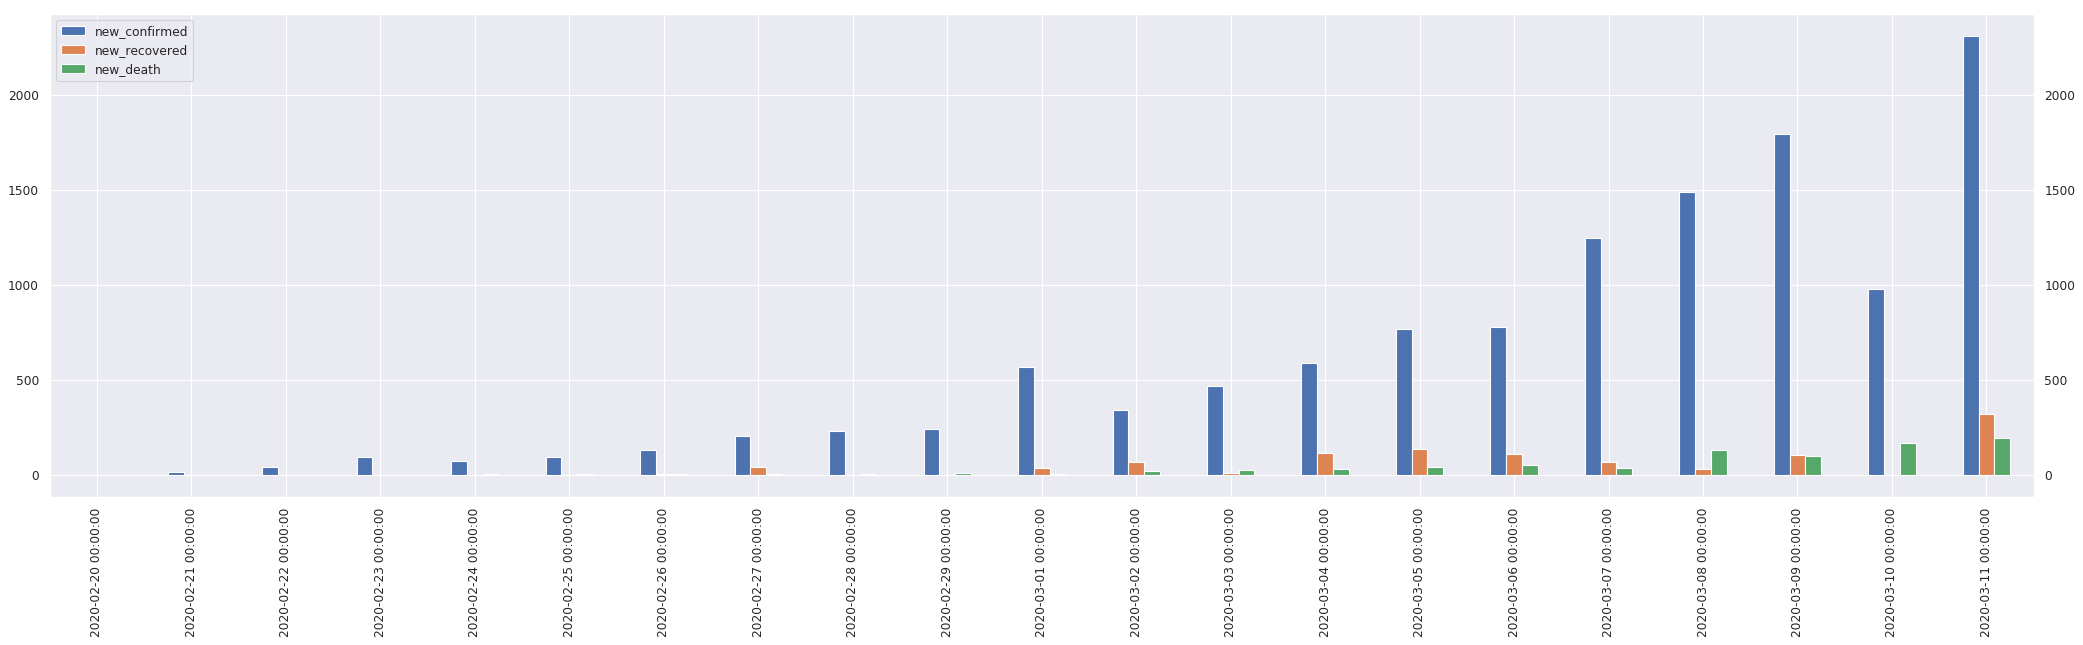

In [15]:
cbr_italy.plot_daily_stats()

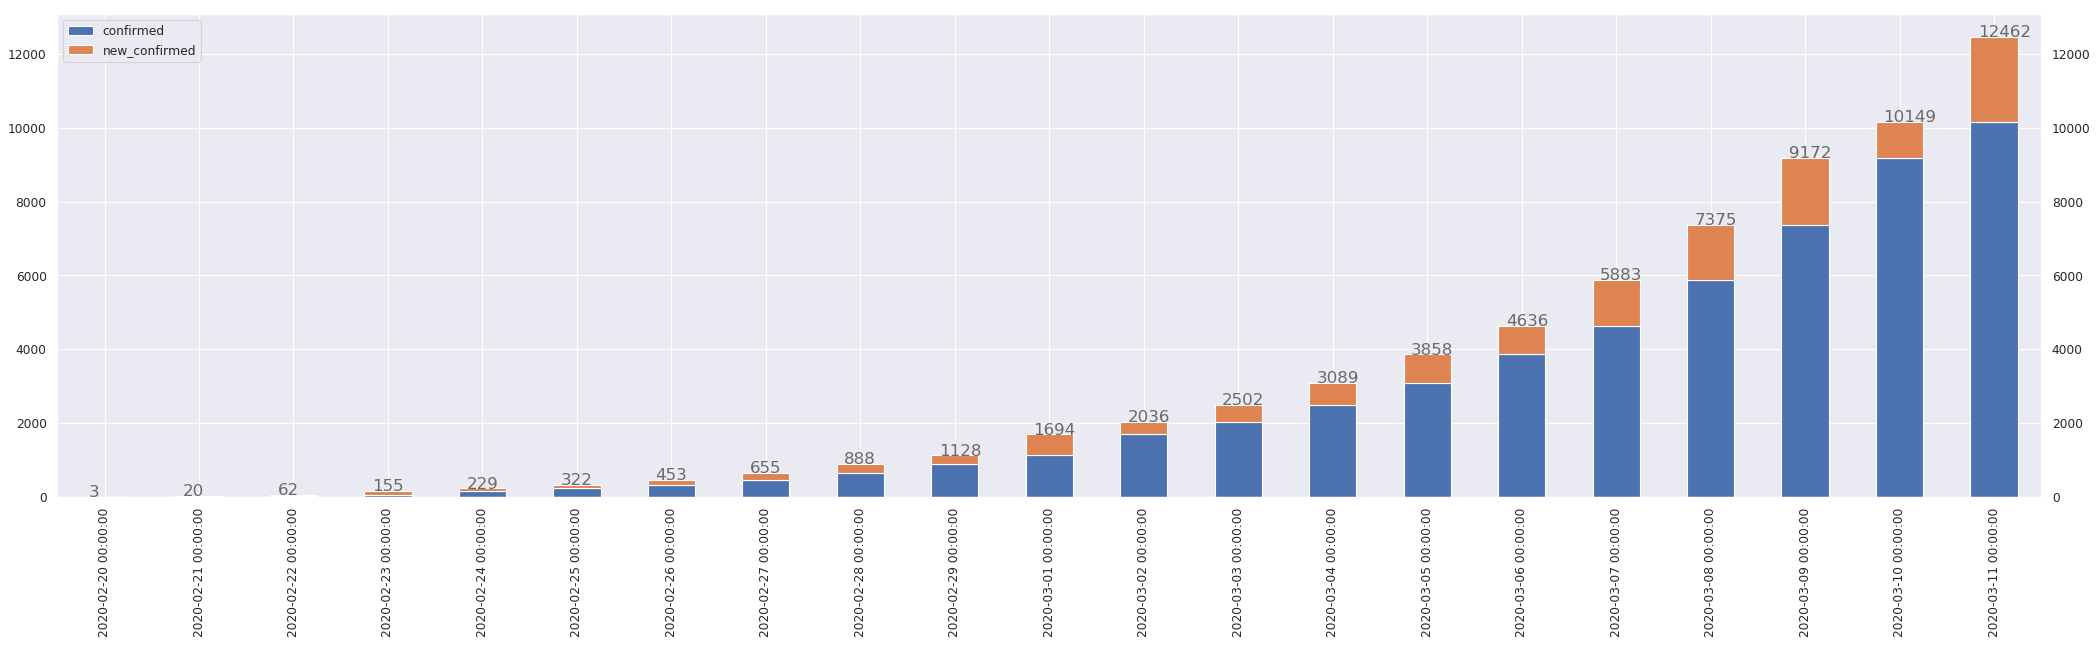

In [16]:
cbr_italy.plot_daily_stacked()

In [17]:
cbr_france = CasesByRegion('France')
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-07,952,12,11,296,0,2
2020-03-08,1129,12,19,177,0,8
2020-03-09,1212,12,19,83,0,0
2020-03-10,1787,12,33,575,0,14
2020-03-11,2284,12,48,497,0,15


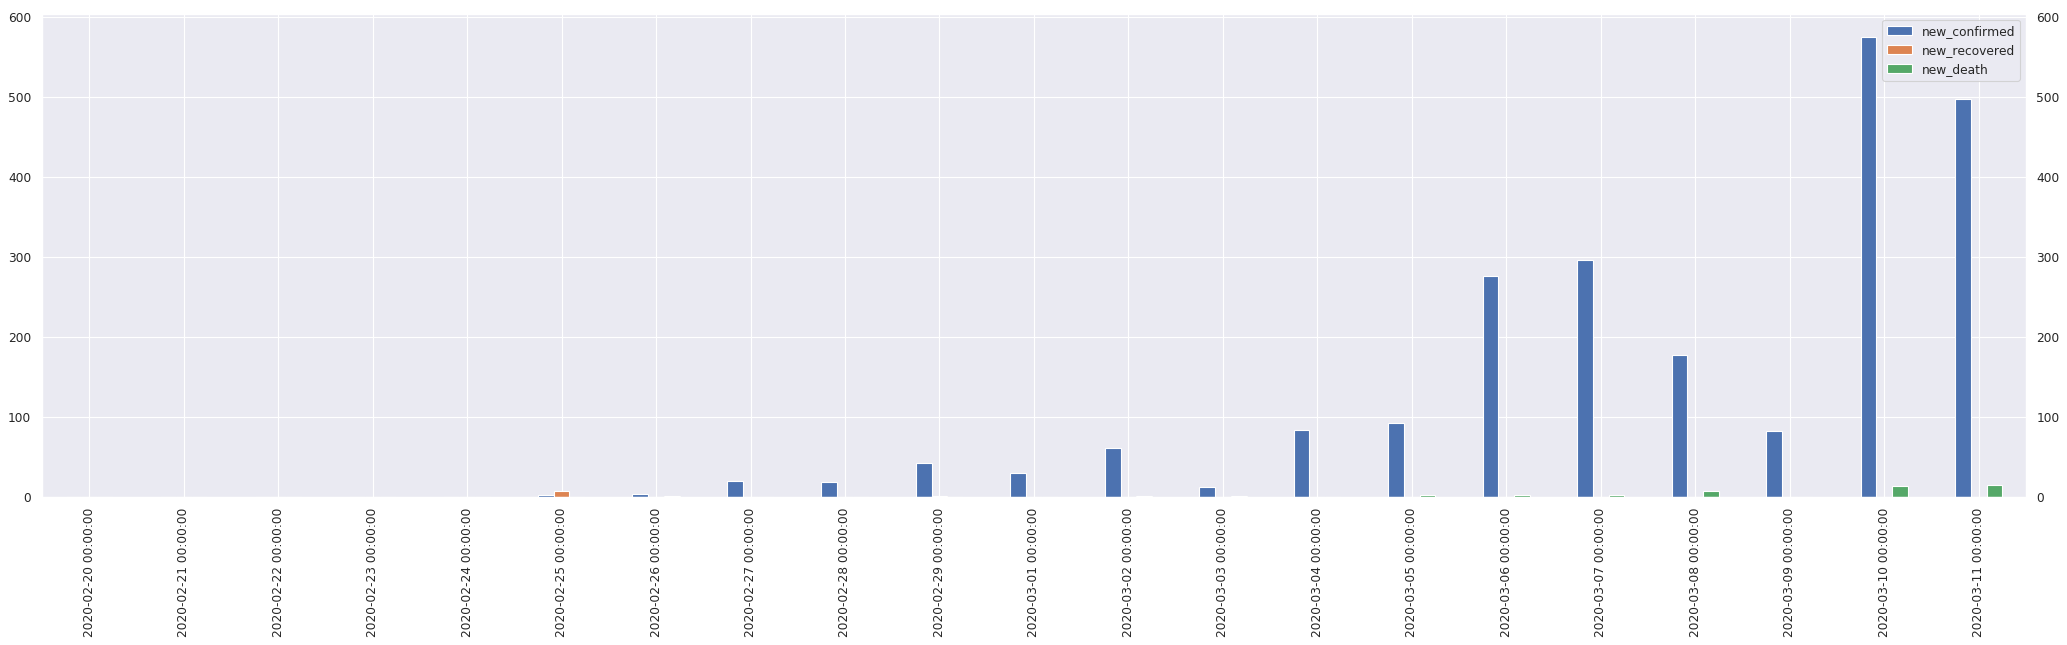

In [18]:
cbr_france.plot_daily_stats()

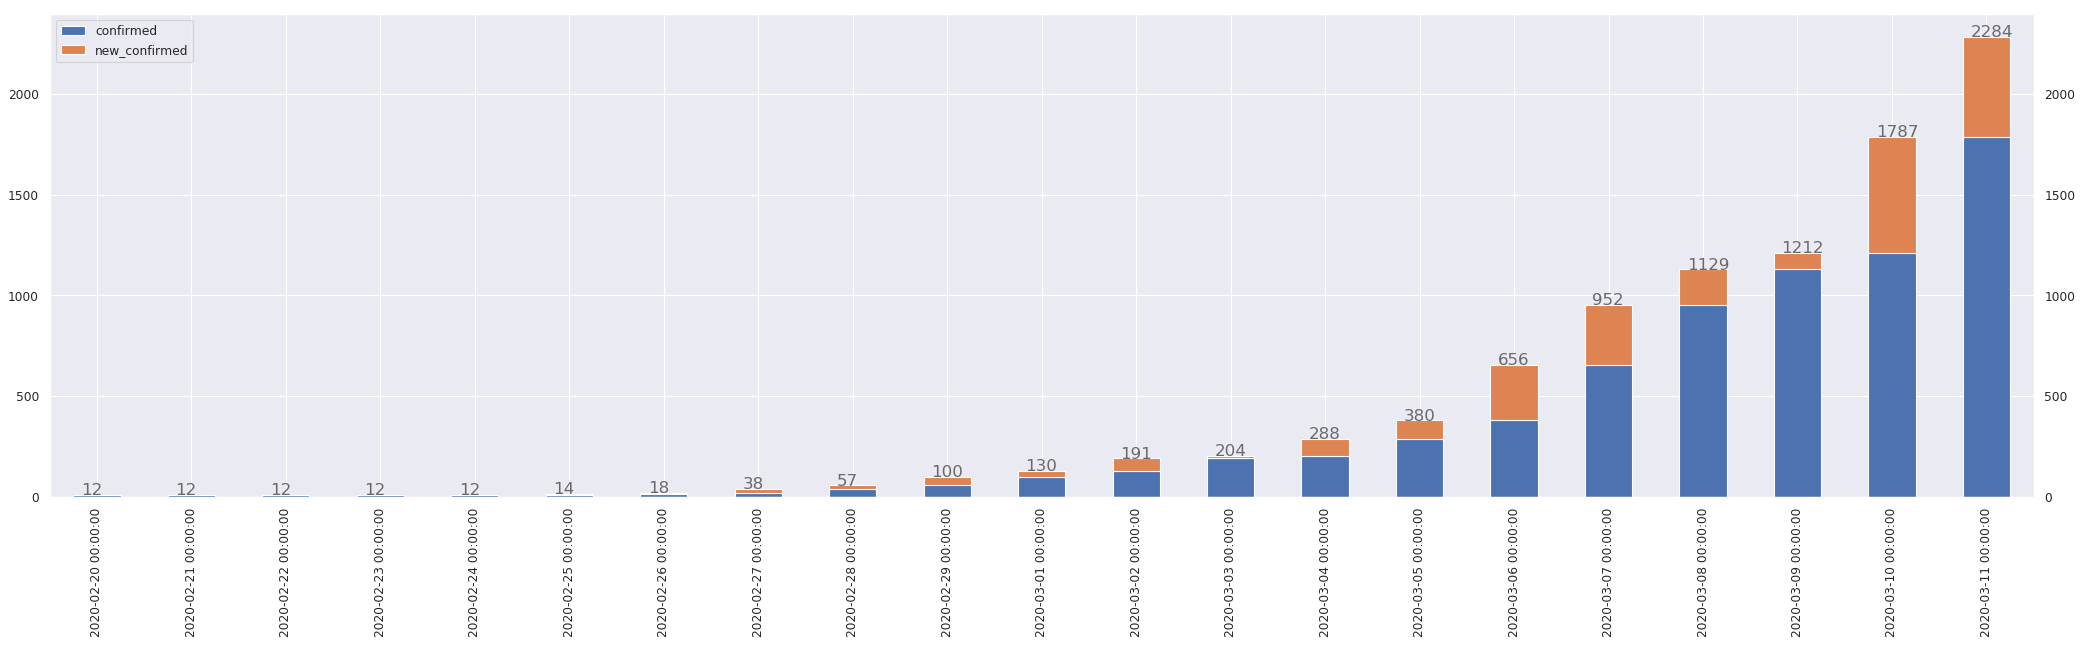

In [19]:
cbr_france.plot_daily_stacked()

In [20]:
cbr_spain = CasesByRegion('Spain')
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-07,500,30,10,100,28,5
2020-03-08,673,30,17,173,0,7
2020-03-09,1073,32,28,400,2,11
2020-03-10,1695,32,35,622,0,7
2020-03-11,2277,183,54,582,151,19


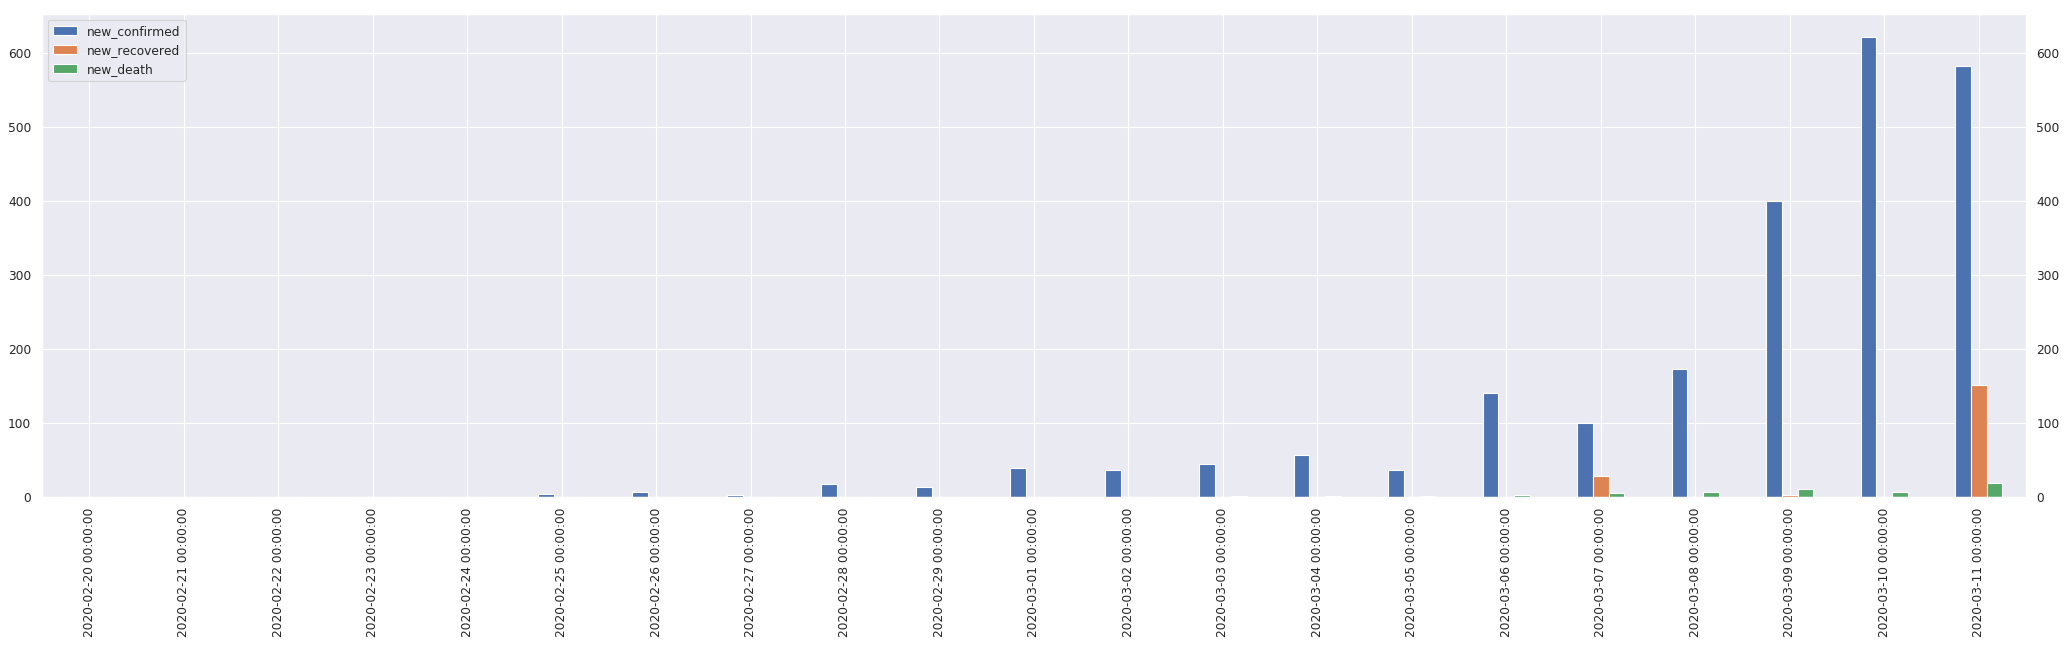

In [21]:
cbr_spain.plot_daily_stats()

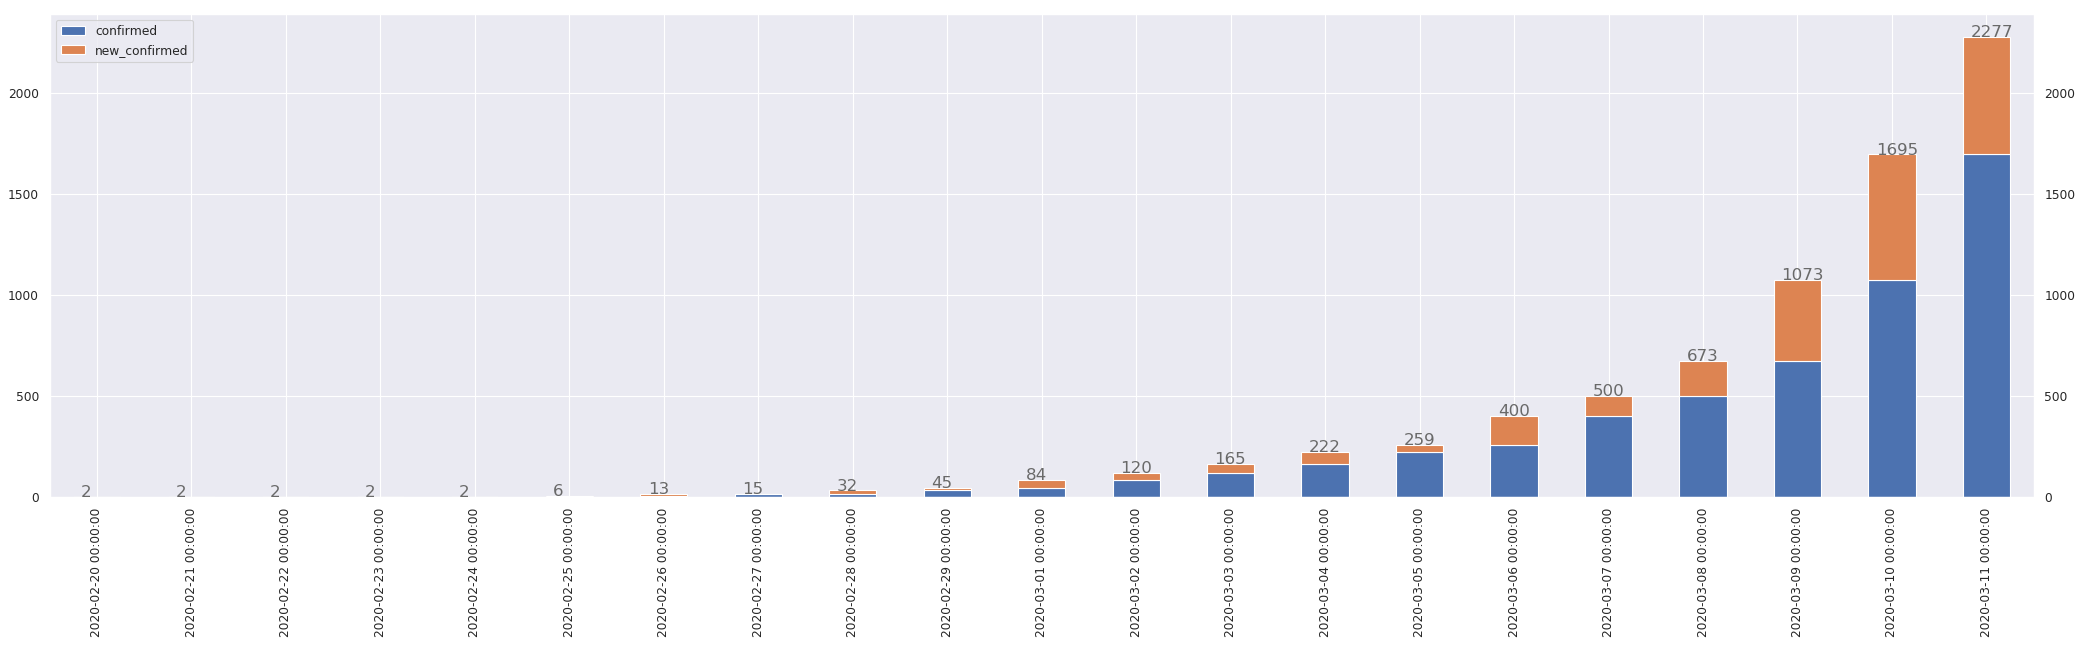

In [22]:
cbr_spain.plot_daily_stacked()

In [23]:
cbr_south_korea = CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-07,7041,135,44,448,0,2
2020-03-08,7314,118,50,273,-17,6
2020-03-09,7478,118,53,164,0,3
2020-03-10,7513,247,54,35,129,1
2020-03-11,7755,288,60,242,41,6


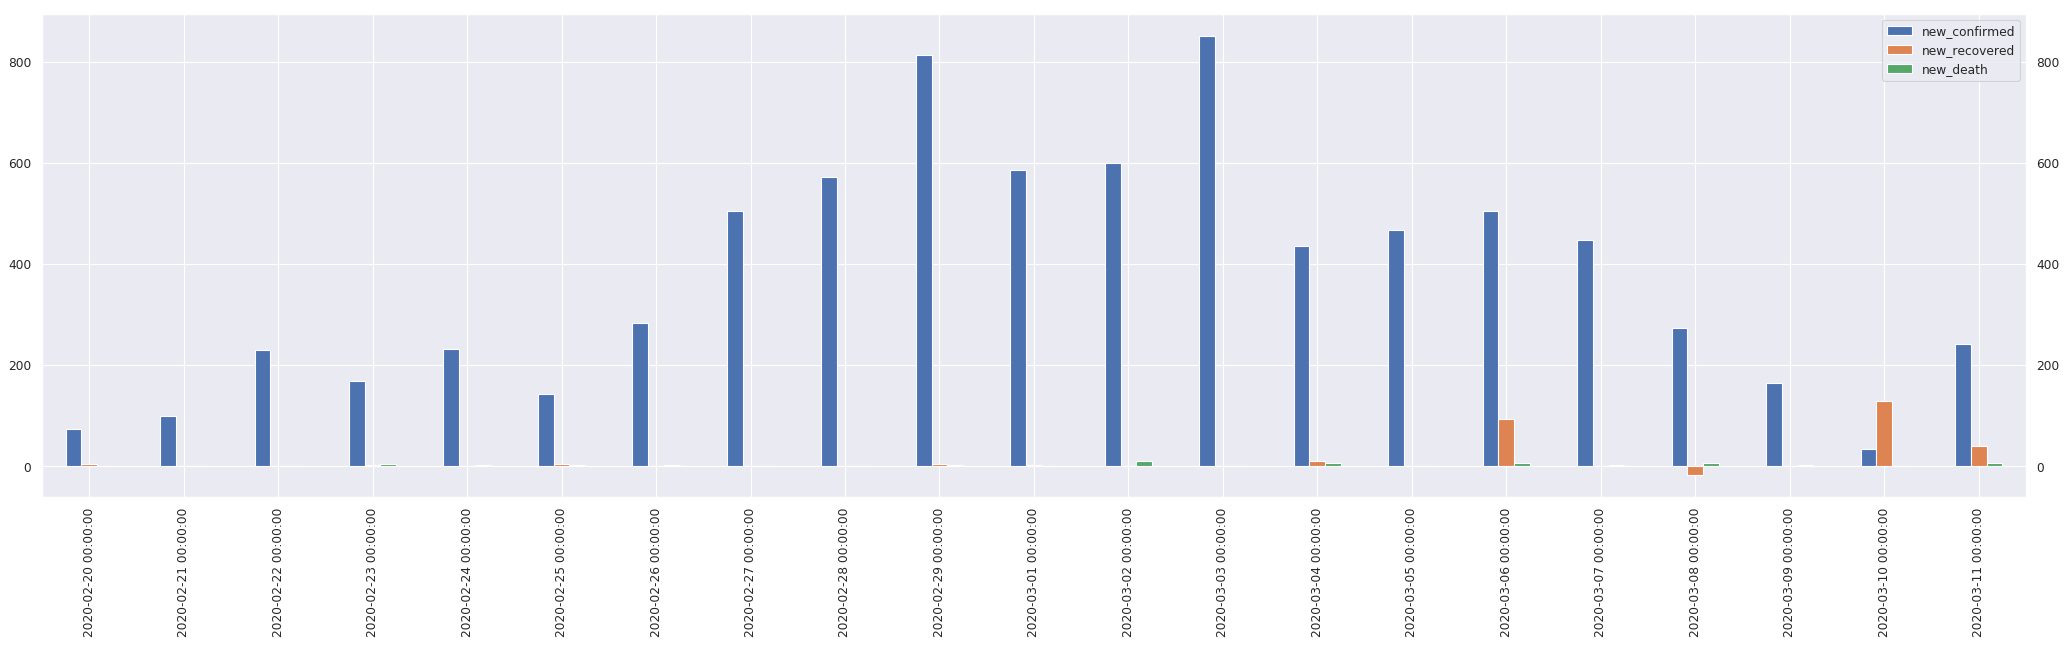

In [24]:
cbr_south_korea.plot_daily_stats()

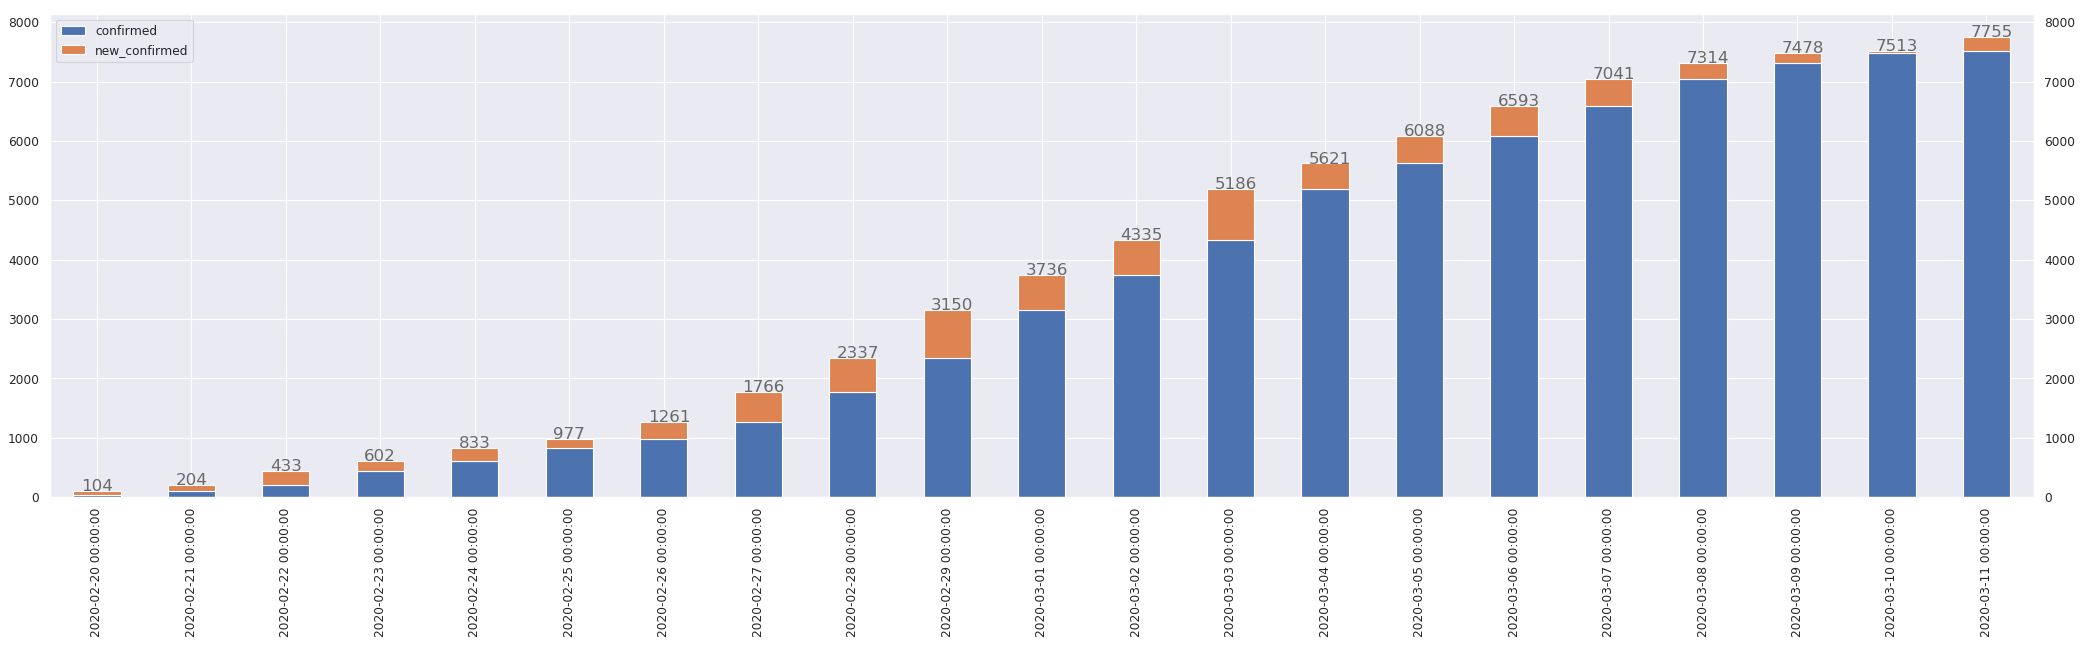

In [25]:
cbr_south_korea.plot_daily_stacked()

In [26]:
cbr_uk = CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-07,207,18,2,43,10,0
2020-03-08,274,18,3,67,0,1
2020-03-09,322,18,4,48,0,1
2020-03-10,384,19,6,62,1,2
2020-03-11,459,19,8,75,0,2


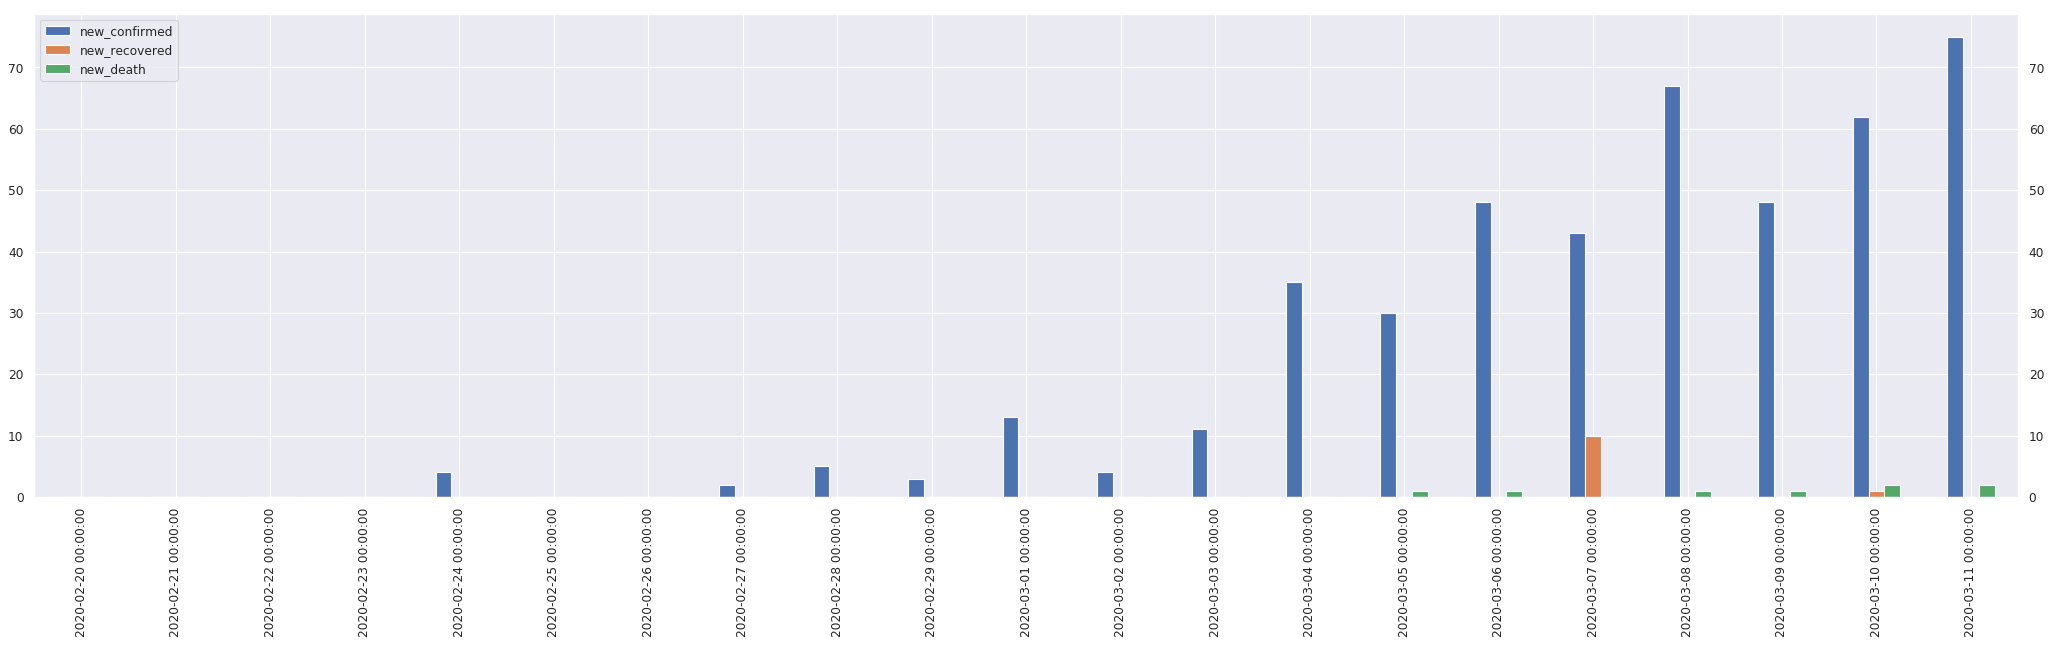

In [27]:
cbr_uk.plot_daily_stats()

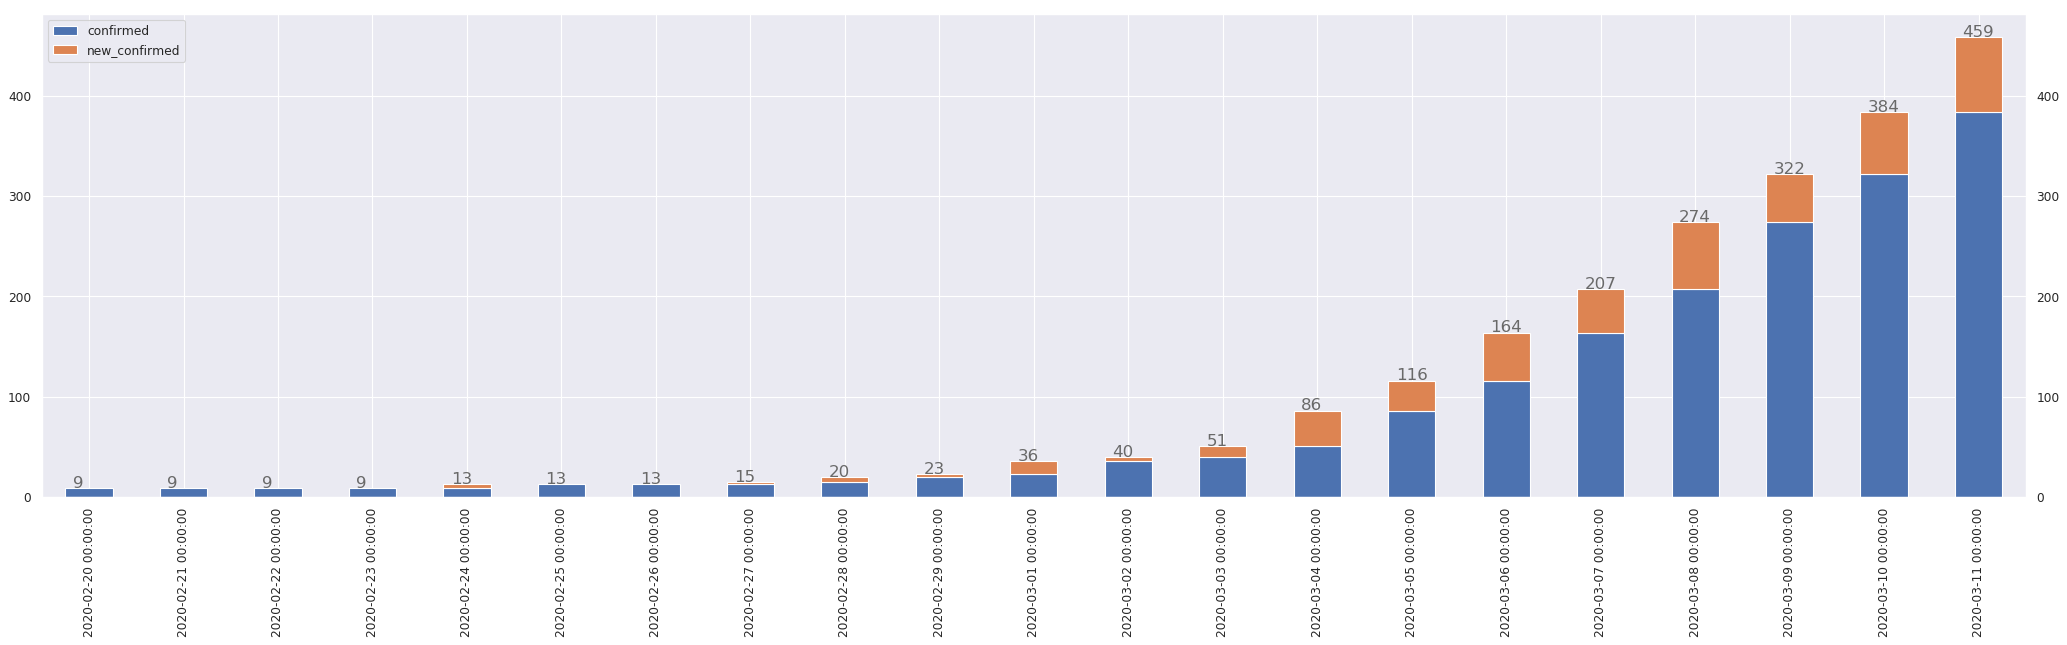

In [28]:
cbr_uk.plot_daily_stacked()

In [29]:
# cbr_us = CasesByRegion('US')
# cbr_us.tail()

In [30]:
# cbr_us.plot_daily_stats()

In [31]:
# cbr_us.plot_daily_stacked()

In [32]:
cbr_switzerland = CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-07,268,3,1,54,0,0
2020-03-08,337,3,2,69,0,1
2020-03-09,374,3,2,37,0,0
2020-03-10,491,3,3,117,0,1
2020-03-11,652,4,4,161,1,1


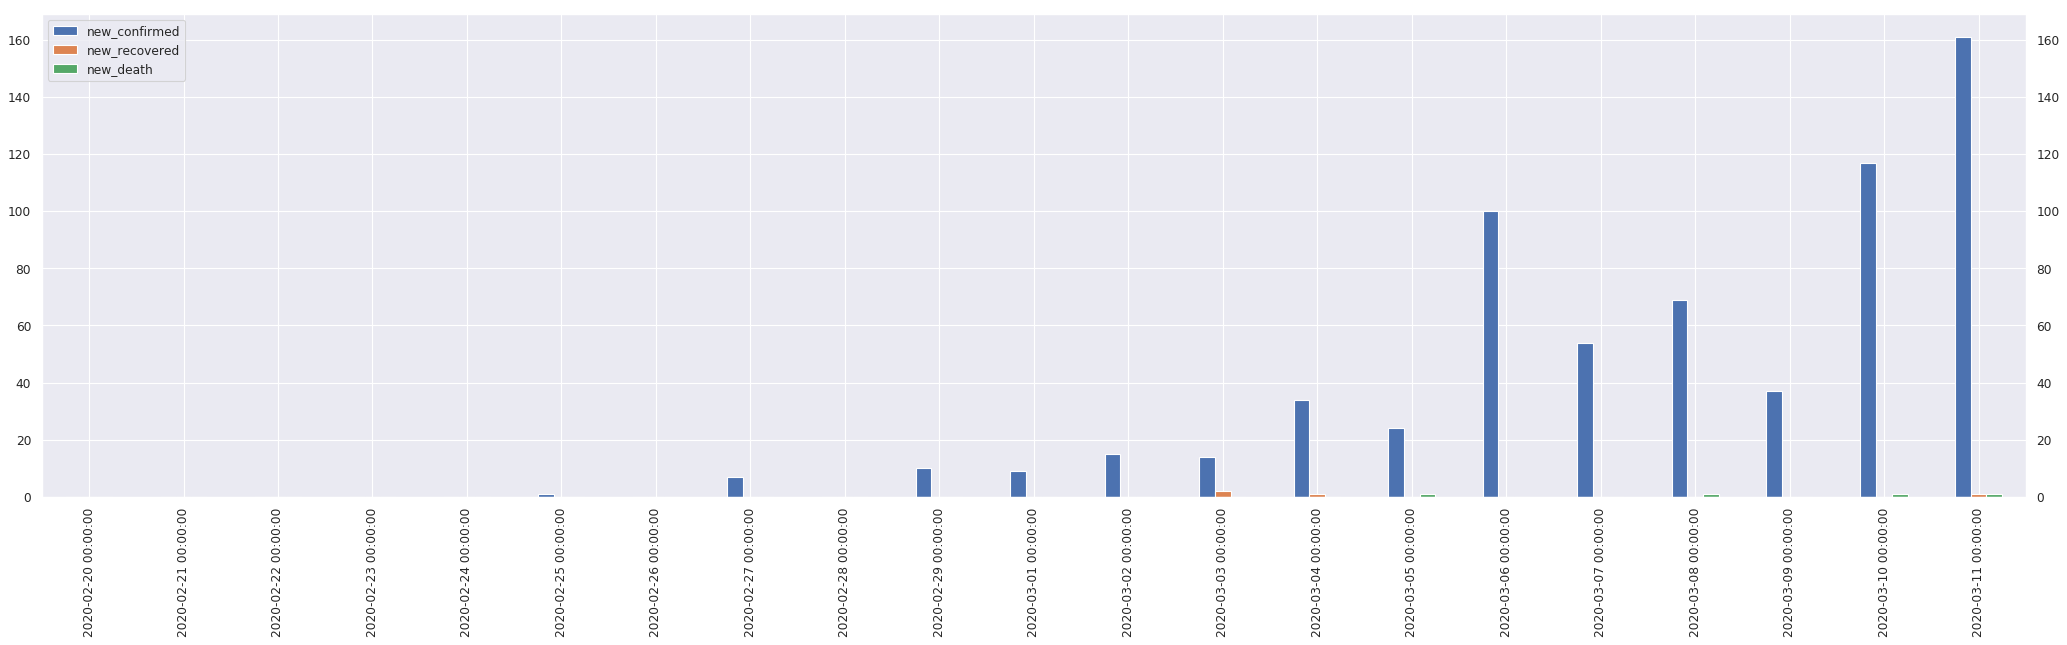

In [33]:
cbr_switzerland.plot_daily_stats()

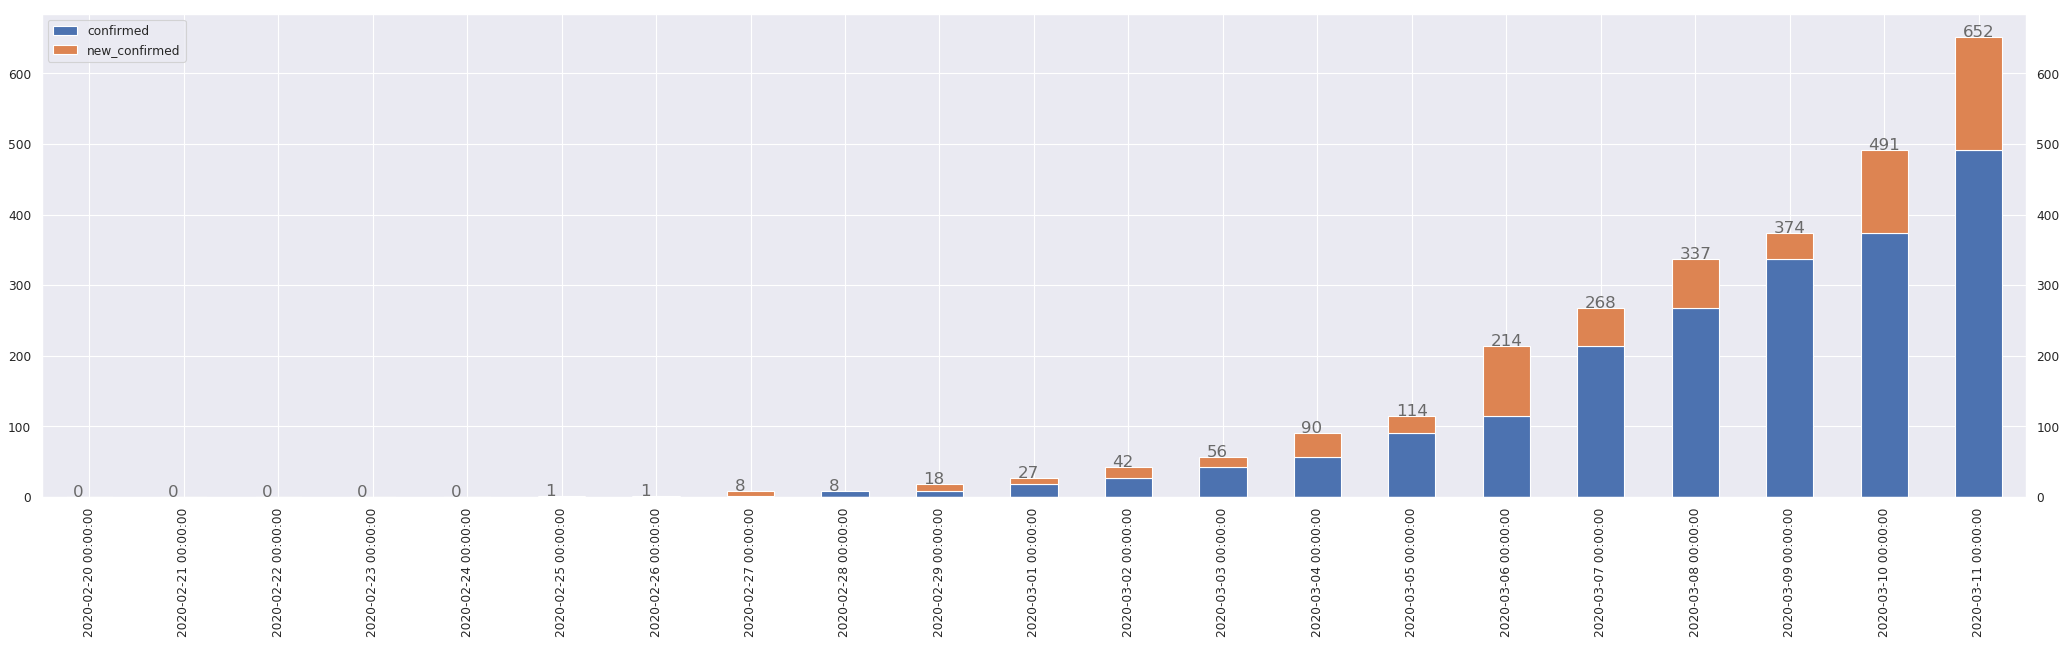

In [34]:
cbr_switzerland.plot_daily_stacked()

In [35]:
def get_country_overview():
    ldf_confirmed = time_series_19_covid_confirmed[['Country/Region', columns[-1]]].groupby(['Country/Region']).sum()
    # confirmed_column_name = 'confirmed_' + str(pd.to_datetime(columns[-1]).date())
    confirmed_column_name = 'confirmed'
    ldf_confirmed.columns = [confirmed_column_name]
    ldf_recovered = time_series_19_covid_recovered[['Country/Region', columns[-1]]].groupby(['Country/Region']).sum()
    # recovered_column_name = 'recovered_' + str(pd.to_datetime(columns[-1]).date())
    recovered_column_name = 'recovered'
    ldf_recovered.columns = [recovered_column_name]
    ldf_death     = time_series_19_covid_death[['Country/Region', columns[-1]]].groupby(['Country/Region']).sum()
    # death_column_name     = 'death_' + str(pd.to_datetime(columns[-1]).date())
    death_column_name     = 'death'
    ldf_death.columns     = [death_column_name]
    
    ldf                = pd.concat([ldf_confirmed, ldf_recovered, ldf_death], axis=1)
    ldf['death_rate']  = ldf[death_column_name] / ldf[confirmed_column_name] * 100.0
    ldf['death_rate_'] = ldf[death_column_name] / (ldf[recovered_column_name] + ldf[death_column_name] + 1.0) * 100.0
    ldf.index.name = ldf.index.name + '_' + str(pd.to_datetime(columns[-1]).date())
    return ldf.sort_values(['death_rate'], ascending=False)


df_co = get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-03-11,,,,,
Morocco,5,0,1,20.000000,50.000000
Bulgaria,7,0,1,14.285714,50.000000
Panama,8,0,1,12.500000,50.000000
Iraq,71,15,7,9.859155,30.434783
Albania,12,0,1,8.333333,50.000000


In [36]:
df_co[df_co.confirmed > 100].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-03-11,,,,,
Italy,12462,1045,827,6.6,44.2
Iran,9000,2959,354,3.9,10.7
China,80921,61644,3161,3.9,4.9
US,2384,19,68,2.9,77.3
Spain,2277,183,54,2.4,22.7
Japan,639,118,15,2.3,11.2
Australia,128,21,3,2.3,12.0
France,2284,12,48,2.1,78.7
United Kingdom,459,19,8,1.7,28.6
